In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import utm
import matplotlib.ticker as ticker
from itertools import groupby
import os, os.path
import seaborn as sns
from datetime import datetime
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn import preprocessing
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import davies_bouldin_score
from scipy.special import rel_entr
from scipy.special import kl_div

In [2]:
# load the data set
df = pd.read_csv('BrightKite_converted/user_0.csv', encoding='utf-8')
df.head()

,Latitude,Longitude,Time
0,4.415704e+06,493945.771508,6.034444
1,4.415670e+06,494140.844597,3.815000
2,4.400062e+06,500079.415714,18.430833
3,4.400311e+06,500313.797543,0.363056
4,4.400289e+06,500288.098353,23.530833


In [3]:
coords = df[['Latitude', 'Longitude']].to_numpy()
lats_xy = coords[:,0]
longs_xy = coords[:,1]
user_time = df['Time'].values.tolist()

In [4]:
#Finding minimum and maximum points from user data
lats_index_min = np.argmin(lats_xy)
lats_index_max = np.argmax(lats_xy)
longs_index_min = np.argmin(longs_xy)
longs_index_max = np.argmax(longs_xy)

#Defining the boundary points
p1_xy = (longs_xy[longs_index_min],lats_xy[lats_index_min])
p2_xy = (longs_xy[longs_index_min],lats_xy[lats_index_max])
p3_xy = (longs_xy[longs_index_max],lats_xy[lats_index_min])
p4_xy = (longs_xy[longs_index_max],lats_xy[lats_index_max])

In [5]:
#Initialize values to partition along number of grids n each axis
x=10
y=10
z=24

### Mapping of points in a 3D space-time grid and calculate distance using KL-divergence after addition of each new point

In [6]:
X = np.linspace((longs_xy[longs_index_min]),(longs_xy[longs_index_max]),x)
Y = np.linspace((lats_xy[lats_index_min]),(lats_xy[lats_index_max]), y)
Z = np.linspace(0,z,z)

point_count_inside_grid = np.zeros((1,x*y*z))
flat_hist = np.ones((1,x*y*z))

kl_pq = np.zeros((1,len(coords)))

grids_index = np.arange(1, 2401).reshape(10, 10, 24)

for counter in range(len(coords)):
    p_lat = lats_xy[counter]
    p_long = longs_xy[counter]
    p_time = user_time[counter]
    for t in range(z):
        if ((p_time>Z[t] and p_time<Z[t+1]) or (p_time==Z[t]) or (p_time==0)):
            for yax in range(y):
                if (((p_lat>Y[yax]) and (p_lat<Y[yax+1])) or (p_lat==Y[yax])):
                    for xax in range(x):
                        if (((p_long>X[xax]) and (p_long<X[xax+1])) or (p_long==X[xax])):
                            found_at = grids_index[xax,yax,t]
                            point_count_inside_grid[:,int(found_at)] += 1
                            normalizedData = (point_count_inside_grid-np.min(point_count_inside_grid))/(np.max(point_count_inside_grid)-np.min(point_count_inside_grid))
                            #distance = sum(rel_entr(normalizedData, flat_hist)[0,:])
                            distance = sum(kl_div(normalizedData[0,:], flat_hist[0,:]))
                            #kl_pq[:,counter] = abs(distance)
                            kl_pq[:,counter] = distance

### Normalizing the data points

In [7]:
scaler = MinMaxScaler()
model=scaler.fit(df)
scaled_data=model.transform(df)
normalized_data = pd.DataFrame(scaled_data, columns = ['Latitude','Longitude','Time'])

### Plot raw normalized data points

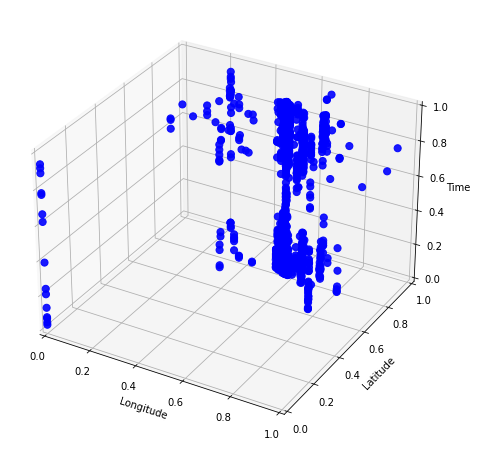

In [8]:
fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection ="3d")
scatter = ax.scatter3D(normalized_data['Longitude'], normalized_data['Latitude'], normalized_data['Time'],color='blue',alpha=0.9, s=50)
plt.xlim(0,1)
plt.ylim(0,1)
ax.set_zlim(0,1)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Time')
plt.show()

In [9]:
min_pts = (5/100)*len(lats_xy)
epsilon = 0.2

### Clustering of raw normalized data

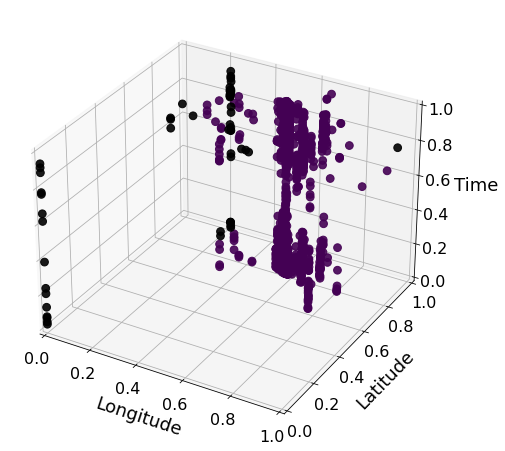

In [10]:
db = DBSCAN(eps=epsilon, min_samples=min_pts, algorithm='ball_tree', metric='euclidean').fit(normalized_data)
to_plot=normalized_data
to_plot.loc[:,'Label']=db.labels_
noise_points = to_plot[to_plot.Label==-1]
to_plot=to_plot[to_plot.Label!=-1]
#Plot clustered points
fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection ="3d")
scatter = ax.scatter3D(to_plot['Longitude'], to_plot['Latitude'], to_plot['Time'],c=to_plot['Label'],alpha=0.9, s=60)
ax.scatter3D(noise_points['Longitude'], noise_points['Latitude'], noise_points['Time'],color='black',alpha=0.9, label='Noise', s=60)
plt.xlim(0,1)
plt.ylim(0,1)
ax.set_zlim(0,1)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.zaxis.set_tick_params(labelsize=16)
ax.set_xlabel('Longitude', fontsize=18,labelpad=10)
ax.set_ylabel('Latitude', fontsize=18,labelpad=10)
ax.set_zlabel('Time', fontsize=18,labelpad=15)
#first_legend = ax.legend(*scatter.legend_elements(),loc = "upper right", title="Clusters", ncol=4, frameon=True)
#plt.gca().add_artist(first_legend)
#plt.legend(loc='upper left')
plt.show()

In [11]:
#Computing "the Silhouette Score"
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(normalized_data, db.labels_))

Silhouette Coefficient: 0.664


In [12]:
print(davies_bouldin_score(normalized_data, db.labels_))

0.7930031843790823


In [13]:
# get the number of clusters
num_clusters = len(set(db.labels_))
print(num_clusters)

2


### Find points that can be transmitted directly

In [14]:
threshold = 0.08
delta_2 = 10/100

In [15]:
max_limit = (threshold/100)*len(coords) 
new_data = []
scaled_points = []
for temp in range(kl_pq.size-1):
    if kl_pq[:,temp] != 0:
        percent_change = ((kl_pq[:,temp+1]-kl_pq[:,temp])/kl_pq[:,temp])*100
        if percent_change < delta_2:
            new_data.append(df.iloc[temp].tolist())
            scaled_points.append(scaled_data[temp].tolist())

In [16]:
new_df = pd.DataFrame(new_data, columns = ['Latitude','Longitude','Time'])
normalized_data = pd.DataFrame(scaled_points, columns = ['Latitude','Longitude','Time'])

In [17]:
coords = new_df[['Latitude', 'Longitude']].to_numpy()
lats_xy = coords[:,0]
longs_xy = coords[:,1]
user_time = new_df['Time'].values.tolist()
point_count_inside_grid = np.zeros((1,2400))
counting = np.zeros((1,2400))
found_grid_index = []
d=1
new_points = []
new_scaled_points = []

In [18]:
# Store maximum of max_limit % points in a grid
for counter in range(len(coords)):
    p_lat = lats_xy[counter]
    p_long = longs_xy[counter]
    p_time = user_time[counter]
    for t in range(z):
        if ((p_time>Z[t] and p_time<Z[t+1]) or (p_time==Z[t]) or (p_time==0)):
            for yax in range(y):
                if (((p_lat>Y[yax]) and (p_lat<Y[yax+1])) or (p_lat==Y[yax])):
                    for xax in range(x):
                        if (((p_long>X[xax]) and (p_long<X[xax+1])) or (p_long==X[xax])):
                            found_at = grids_index[xax,yax,t]
                            point_count_inside_grid[:,int(found_at)] += 1
                            if point_count_inside_grid[:,int(found_at)] <= max_limit:
                                new_points.append(new_df.iloc[counter].tolist())
                                new_scaled_points.append(normalized_data.iloc[counter].tolist())

In [19]:
new_df = pd.DataFrame(new_points, columns = ['Latitude','Longitude','Time'])
normalized_data = pd.DataFrame(new_scaled_points, columns = ['Latitude','Longitude','Time'])

### Plot directly transmitted normalized data points

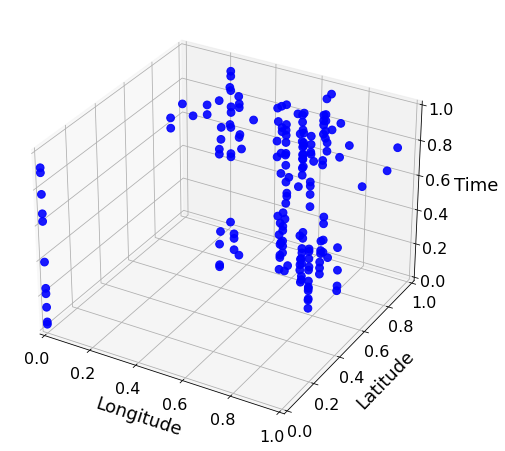

In [20]:
fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection ="3d")
scatter = ax.scatter3D(normalized_data['Longitude'], normalized_data['Latitude'], normalized_data['Time'],color='blue',alpha=0.9, s=60)
plt.xlim(0,1)
plt.ylim(0,1)
ax.set_zlim(0,1)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.zaxis.set_tick_params(labelsize=16)
ax.set_xlabel('Longitude', fontsize=18,labelpad=10)
ax.set_ylabel('Latitude', fontsize=18,labelpad=10)
ax.set_zlabel('Time', fontsize=18,labelpad=15)
plt.show()

### Clustering of directly transmitted data points

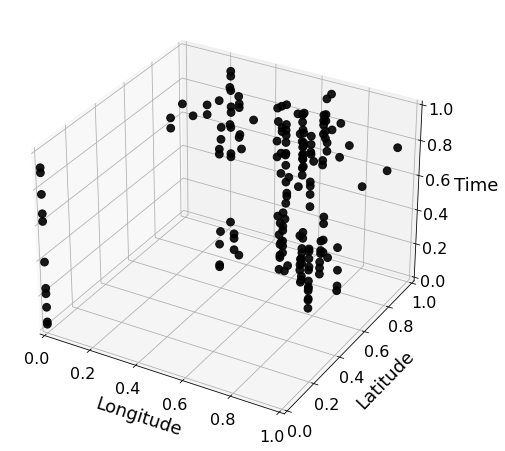

In [21]:
db = DBSCAN(eps=epsilon, min_samples=min_pts, algorithm='ball_tree', metric='euclidean').fit(normalized_data)
to_plot=normalized_data
to_plot.loc[:,'Label']=db.labels_
noise_points = to_plot[to_plot.Label==-1]
to_plot=to_plot[to_plot.Label!=-1]
#Plot clustered points
fig = plt.figure(figsize = (8,8))
ax = plt.axes(projection ="3d")
scatter = ax.scatter3D(to_plot['Longitude'], to_plot['Latitude'], to_plot['Time'],c=to_plot['Label'],alpha=0.9, s=60)
ax.scatter3D(noise_points['Longitude'], noise_points['Latitude'], noise_points['Time'],color='black',alpha=0.9, label='Noise', s=60)
plt.xlim(0,1)
plt.ylim(0,1)
ax.set_zlim(0,1)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
ax.zaxis.set_tick_params(labelsize=16)
ax.set_xlabel('Longitude', fontsize=18,labelpad=10)
ax.set_ylabel('Latitude', fontsize=18,labelpad=10)
ax.set_zlabel('Time', fontsize=18,labelpad=15)
#first_legend = ax.legend(loc='upper left')
#plt.gca().add_artist(first_legend)
#plt.legend(*scatter.legend_elements(),loc = "upper right", title="Clusters", ncol=5, frameon=True)
plt.show()

In [22]:
#Computing "the Silhouette Score"
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(normalized_data, db.labels_))

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [ ]:
print(davies_bouldin_score(normalized_data, db.labels_))

In [ ]:
# get the number of clusters
num_clusters = len(set(db.labels_))
print(num_clusters)